# Feature Engineering
The purpose of this section is to label each post with all the stock tickers mentioned inside, to explore the ditribution of stock mentions and to preprocess natural language for sentiment analysis.

In [21]:
library(tidyverse);
library(quantmod);
library(tidyquant);

## Response variable creation: R50 index  
As we previously saw, not all the stocks have enough observations to cover the entire observed period, so, instead of deleting most of the tickers, we will create an index that will represent the meme stocks as a whole. To do this we will create an index based on the 50 most popular stocks on Robinhood in march 2021, the R50. 

This is because Robinhood played a key role in the meme stocks phenomenon, as it allowed retail traders to trader extremely risky instruments with very low transaction fees, so it was the main broker utilized by the commuity(in fact there is a large overlap with the 50 most mentioned stocks). Robinhood was also in the center of a massive discussion when it halted the trading of Gamestop stocks for multiple times, making it an anthagonist to the Wallstreetbets subreddit.

Note that some of the stocks included in the r50 are not listed anymore, but they are  included in the final calculations of r50.csv. 

In [22]:
# Read the CSV file "vader_sentiment.csv" into the wsb data frame
wsb <- read.csv(file = "../data/vader_sentiment.csv",
        header = TRUE,
        sep = ",",
        dec = ".")

# Parse the timestamp column as dates
wsb$timestamp <- parse_date(wsb$timestamp)

# Select timestamp, number of comments, number of upvotes and sentiment and remove duplicate rows
wsb <- wsb[c(5, 2, 4, 8)] %>% distinct()

# Define a list of the 50 most popular stocks on Robinhood in March 2021
r50 <- c("AAPL", "TSLA", "AMC", "SNDL", "F", "GE", "NIO",
        "MSFT", "DIS", "AMZN", "NOK", "GME", "ZOM",
        "AAL", "PLUG", "PFE", "ACB", "CCVI", "CCL", "GPRO", "DAL",
        "OGI", "PLTR", "SNAP", "CTRM", "BABA",
        "MRNA", "BAC", "NFLX", "BB", "CGC", "FCEL", "IDEX",
        "AMD", "TLRY", "META", "NCLH", "T", "GM",
        "SPCE", "UAL", "BA", "KO", "SBUX", "CRON", "WKHS")#"APHA", "NAKD", "TWTR", "ZNGA"

# Retrieve stock prices for r50 stocks
stocks <- r50 %>%
        tq_get(get = "stock.prices",
                from = "2021-01-27",
                to = "2021-08-16");


The weights of the stocks in the portfolio will be based on the number of mentions we calculated in data_processing.ipynb, in particular, we will model the weights using the mean and standard deviation of the number of mentions to model a log-normal distribution. Since the standard deviation is much larger than the mean we will log-transform the number of mentions.

We will then have the top 10 most mentioned stock to weight around 60% of the index.

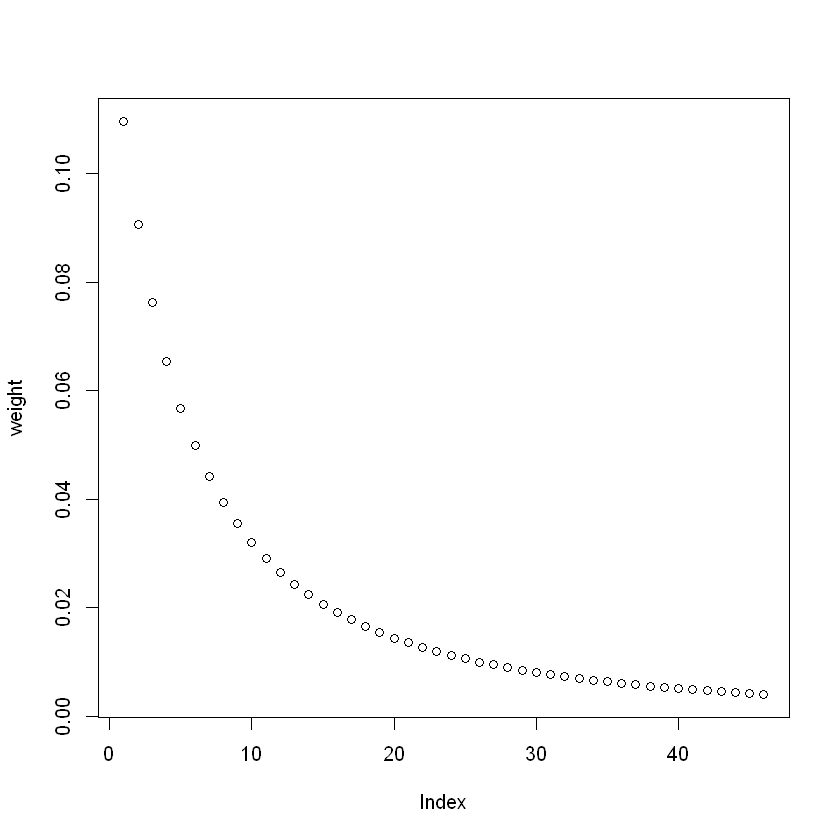

In [23]:
weight <- 1 - plnorm(rep(2:47), meanlog = 1.297974, sdlog =1.298812)
weight <- weight/sum(weight)
plot(weight)

# Create portfolio dataframe with r50 and weights
pfolio <- cbind(r50,weight) %>% as.data.frame()

The next step will be to create the r50 index by using the weights from the log normal distribution and the stock prices.
After gatherimg this data we will be able to compute the returns and the change in volume of the index.

In [24]:
# Add historical prices to each stock
stocks <- left_join(stocks, pfolio, by = c("symbol" = "r50"))
stocks$weight <- as.numeric(stocks$weight)

# Calculate r50 price and volume
stocks <- stocks %>%
        na.omit() %>%
        group_by(date) %>%
        summarise(
                r50_close = sum(close * weight),
                r50_volume = sum(volume * weight)
                )

stocks <- stocks %>%
        mutate(
                r = Delt(r50_close),                   # Arithmetic difference of the "close" column
                logr = Delt(r50_close, type = "log"),  # Logarithmic difference of the "close" column
                D_vol = Delt(r50_volume),              # Arithmetic difference of the "volume" column
                logD_vol = Delt(r50_volume, type = "log")  # Logarithmic difference of the "volume" column
        )
# Remove t=0
stocks <- filter(stocks, date != "2021-01-27")

# Perform a full join between the "wsb" and "stocks" data frames based on matching timestamps and dates
r50 <- full_join(wsb, stocks, by = c("timestamp" = "date"))


head(stocks)

date,r50_close,r50_volume,r,logr,D_vol,logD_vol
<date>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
2021-01-28,89.54390,141633569,-0.0272334284,-0.0276111314,-0.30190740,-0.35940352
2021-01-29,88.03582,124084114,-0.0168417996,-0.0169852355,-0.12390745,-0.13228355
2021-02-01,90.16893,103476143,0.0242300169,0.0239411272,-0.16608066,-0.18161859
2021-02-02,90.26785,97226568,0.0010969877,0.0010963864,-0.06039629,-0.06229708
2021-02-03,90.33416,71477946,0.0007346479,0.0007343781,-0.26483113,-0.30765505
2021-02-04,90.60450,69402165,0.0029926991,0.0029882299,-0.02904087,-0.02947090


## Adaptation of sentiment to r50

For sake of simplicity we will use data in daily timeframe, but if I will be able to gather hourly data I might expand the project to encorporate this change. So since we have a varying number of posts per day we will need to summarize the sentiment for each day. To do so we will calculate the daily sentiment average and variance. In addition to that we will save the number of posts, comments and upvotes as well.  

In [25]:
r50$count = rep(1, nrow(r50))